In [ ]:
!pip install gym_super_mario_bros==7.4.0
!pip install gym==0.26.2
!pip install nes_py==8.2.1

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch,gym
from dataclasses import dataclass
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym.wrappers import GrayScaleObservation,FrameStack,ResizeObservation
from gym.vector import AsyncVectorEnv
import numpy as np

@dataclass(frozen=False)
class hypers:
    seed : int = 42
    lambda_ : float = .99
    gamma : float = .99
    epsilon : float = .2
    lr : float = 1e-4
    critic_coeff : float = 5e-1
    policy_ceoff : int = 3e3
    entropy_coeff : float = 1e-1
    skip_frame : int = 4
    num_stack : int  = 4
    obs_shape : tuple[int,int] = (100,100) # observation shape
    num_env : int = 30 
    num_game : int = 1_000
    batchsize : int = 512 
    minibatch : int = 16
    optim_steps : int = 10
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

configs = hypers()

torch.manual_seed(configs.seed)
np.random.seed(configs.seed)
torch.cuda.manual_seed(configs.seed)

In [ ]:
class CustomEnv(gym.Wrapper): 
        def __init__(self,env,skip):
            super().__init__(env)
            self.skip = skip
            self.score = 0
            
        def step(self, action):
            total_reward = 0  
            for _ in range(self.skip):
                obs,reward,done,truncared,info = self.env.step(action)
                total_reward += reward
                if done:
                    obs,info = self.reset()
                    return obs,(total_reward/10.),done,truncared,info
            return obs,(total_reward/10.),done,truncared,info

        def reset(self, **kwargs):
            self.score = 0
            obs,info = self.env.reset(**kwargs)
            return obs,info

def make_env():
    def env():
        x = gym_super_mario_bros.make("SuperMarioBros-v0", apply_api_compatibility=True)
        x = JoypadSpace(x, SIMPLE_MOVEMENT)
        x = ResizeObservation(x, configs.obs_shape)
        x = CustomEnv(x, configs.skip_frame)
        x = GrayScaleObservation(x, keep_dim=True)
        x = FrameStack(x, configs.num_stack) 
        return x
    return AsyncVectorEnv([env for _ in range(configs.num_env)]) 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(32,1,1,0)
        self.conv2 = nn.LazyConv2d(32,3,2,2)
        self.conv3 = nn.LazyConv2d(32,3,2,2)
        self.conv4 = nn.LazyConv2d(32,3,2,2)
        self.output = nn.LazyLinear(512)
        self.policy_head = nn.LazyLinear(7)
        self.value_head = nn.LazyLinear(1)
        self.optim = torch.optim.Adam(self.parameters(),lr=configs.lr)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) 
        x = torch.flatten(x,start_dim=1)  
        x = F.relu(self.output(x))
        policy_output = self.policy_head(x)
        value_output = self.value_head(x)
        return F.softmax(policy_output,-1),value_output

def init_weights(layer):
    if isinstance(layer,(nn.Conv2d,nn.Linear)):
        nn.init.orthogonal_(layer.weight)
        nn.init.constant_(layer.bias,0.0)
     
model = network().to(configs.device)
model.forward(
    torch.rand(
        (1,configs.num_stack,*(configs.obs_shape)),dtype=torch.float32,device=configs.device
    )
)
model.apply(init_weights)
model = nn.DataParallel(model)

#chk = torch.load("/kaggle/input/1_m350/pytorch/default/1/mario350",map_location=configs.device)
#model.load_state_dict(chk["model_state"],strict=True)
#model.module.optim.load_state_dict(chk["optim_state"])

...

Ellipsis

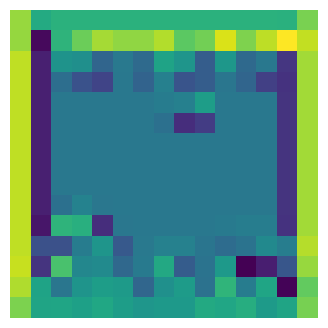

In [ ]:
import matplotlib.pyplot as plt # last conv output visualization

net = nn.Sequential(
    nn.LazyConv2d(32,1,1,0),nn.LazyConv2d(32,3,2,2),nn.LazyConv2d(32,3,2,2),nn.LazyConv2d(32,3,2,2)
)
net(torch.rand(1,4,100,100).to(torch.float32))

env = make_env()
obs,inf = env.reset()
obs = torch.from_numpy(obs).squeeze().to(torch.float32)
output = net(obs)
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(output[0].detach().numpy()), plt.axis("off")
...


In [ ]:
from torch.distributions import Categorical
from collections import deque

class Memory:
    def __init__(self,env : AsyncVectorEnv):
        self.env = env
        self.gamma = configs.gamma
        self._lambda_ = configs.lambda_
        self.data = []
        self.pointer = 0
        self.episode_reward = np.zeros(self.env.num_envs, dtype=np.float32)
        self.finished_reward = deque(maxlen=30)
        self.log_total_steps = deque(maxlen=30)
        self.total_steps = torch.zeros(configs.num_env)
    
    @torch.no_grad()
    def rollout(self,batchsize,network : network):
        self.clear()
        self._observation,_ = self.env.reset()
        for n in range(batchsize):
            self._observation = torch.from_numpy(np.array(self._observation)).squeeze(-1).to(configs.device,torch.float32) / 255.
            policy_output, value = network.forward(self._observation)
            distribution = Categorical(policy_output)
            action = distribution.sample()
            prob = distribution.log_prob(action)
            state,reward,done,_,_ = self.env.step(action.tolist())

            for i in range(self.env.num_envs): 
                self.episode_reward[i] += reward[i] 
                self.total_steps[i] += 1
                if done[i]:
                    self.finished_reward.append(self.episode_reward[i])
                    self.log_total_steps.append(self.total_steps[i])
                    self.episode_reward[i] = 0
                    self.total_steps[i] = 0

            self.data.append(
                [
                    self._observation,
                    torch.tensor(reward,dtype=torch.float32),
                    value,
                    prob,
                    action,
                    torch.from_numpy(done).to(torch.float32),
                    distribution
                ]
            )
            self._observation = state
    
        _,rewards,values,_,_,dones,_ = zip(*self.data)  
        dones = torch.stack(dones).to(configs.device)
        _rewards = torch.stack(rewards).to(configs.device) 
        values = torch.stack(values).squeeze(-1) 
        next_state = torch.from_numpy(np.array(self._observation)).squeeze(-1).to(configs.device,torch.float32) / 255.
        _,next_value = network.forward(next_state)
        _values = torch.cat([values,next_value.permute(-1,0)])
        advantages = torch.zeros_like(_rewards,device=configs.device,dtype=torch.float32)
        gae = 0.0
        for n in reversed(range(len(_rewards))):
            td = _rewards[n] + (self.gamma * _values[n+1] * (1-dones[n])) - _values[n]
            gae = td + (self._lambda_ * self.gamma * gae * (1-dones[n])) 
            advantages[n] = gae

        for data,item in zip(self.data,advantages): # append advantages to data
            data.append(item)

    def sample(self,number):
        output = self.data[self.pointer:self.pointer+number]
        self.pointer+=number
        states,rewards,values,logProb,actions,done,old_logits,advantages = zip(*output)

        states = torch.stack(states)
        actions = torch.stack(actions)
        values = torch.stack(values).squeeze().view(-1)
        logProb= torch.stack(logProb)
        advantages = torch.stack(advantages).view(-1)

        old_logits = [dis.probs for dis in old_logits]
        old_logits = torch.stack(old_logits)
        return (
            states,actions,values,logProb,advantages,old_logits
        )

    def clear(self):
        self.data = []
        self.pointer = 0
    
    def traj_reward(self):
        return self.finished_reward,self.log_total_steps

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.distributions.kl import kl_divergence

class agent:
    def __init__(self,):
        self.env = make_env()
        self.network = model
        self.memory = Memory(self.env)
        self.writter = SummaryWriter("./")

    def save(self,k):
        checkpoint = {
            "model_state" : self.network.state_dict(),
            "optim_state" : self.network.module.optim.state_dict(),
        }
        torch.save(checkpoint,f"./mario{k}")

    def train(self,num_game,batchsize,minibatch,optim_steps):
        for traj in range(num_game):
            self.memory.rollout(batchsize,self.network)

            for _ in range(batchsize//minibatch):
                states,actions,old_values,old_log_prob,advantages,old_logits = self.memory.sample(minibatch) 
                vtarget = (advantages + old_values)
                explained_variance = 1.0 - (torch.var(vtarget - old_values) / torch.var(vtarget + 1e-10))
                cat_old_logits = Categorical(probs=old_logits)
                flat_states = torch.flatten(states,0,1).to(configs.device) # - > [(minibatch * num_env), channel, image_shape]
                
                for _ in range(optim_steps): 
                    p_output,new_values = self.network.forward(flat_states)
                    policy_output = p_output.view(minibatch,configs.num_env,7) # 7 = action space for a single env
                    dist = Categorical(probs=policy_output)  
                    kl = kl_divergence(cat_old_logits,dist).mean() 
                    new_log_prob = dist.log_prob(actions)
                    ratio = torch.exp(new_log_prob - old_log_prob).view(-1) # the first ration should be = 1
                    #norm_advantage  = (_advantages - _advantages.mean()) / (_advantages.std() + 1e-9) 
                    prox1 = ratio * advantages
                    prox2 = torch.clamp(ratio ,1-configs.epsilon,1+configs.epsilon) * advantages

                    loss_policy = -torch.mean(torch.min(prox1,prox2))  
                    loss_critic = F.smooth_l1_loss(new_values.squeeze(),vtarget) * configs.critic_coeff
                    entropy = dist.entropy().mean() * configs.entropy_coeff
                    #_entropy = -(policy_output * torch.log(policy_output + 1e-10)).sum(dim=2)
                    #entropy = _entropy.sum(dim=1).mean() * configs.entropy_coeff
                    
                    total_loss = loss_policy + loss_critic - entropy 

                    self.network.module.optim.zero_grad()
                    total_loss.backward()
                    nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
                    self.network.module.optim.step()
                    
            self.writter.add_scalar("Policy/entropy",dist.entropy().mean(),traj)
            self.writter.add_scalar("Policy/loss policy",loss_policy,traj)
            self.writter.add_scalar("Policy/KL",kl,traj)
            self.writter.add_scalar("Value/values",new_values.detach().mean(),traj)
            self.writter.add_scalar("Value/vtarget",vtarget.mean(),traj)
            self.writter.add_scalar("Value/value loss",loss_critic,traj) 
            self.writter.add_scalar("Value/Explained variance",explained_variance,traj)
            self.writter.add_scalar("main/total loss",total_loss,traj)
            self.writter.add_scalar("main/epi rewards",torch.tensor([self.memory.traj_reward()[0]]).mean(),traj) 
            self.writter.add_scalar("main/total steps",torch.tensor([self.memory.traj_reward()[1]]).mean(),traj)

            epireward = torch.tensor([self.memory.traj_reward()[0]]).mean().tolist()
            print(
                f"{traj}/1k | REWA {epireward:.2f} | ENTR {entropy:.4f} | POLI {loss_policy:.2f} | CRIT {loss_critic:.2f} | TLoss {total_loss:.2f} | Val {new_values.detach().mean():.2f} | Vtarg {vtarget.mean():.2f} | KL {kl:.4f}"
                )
            if traj % 10 == 0 :  
                self.save(traj)
    
    @staticmethod
    def run_training(run=False):
        if run:
            agnt = __class__()
            agnt.train(num_game=configs.num_game,batchsize=configs.batchsize,minibatch=configs.minibatch,optim_steps=configs.optim_steps) 
            
agent.run_training(True)